# 1. Import Python modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from os.path import exists
import PIL
import pathlib
import random
import seaborn

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Dropout, Flatten,Activation, BatchNormalization,MaxPooling2D
from tensorflow.keras import datasets, layers, models
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

from sklearn import metrics
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, f1_score, recall_score

from utilsData import *
from utilsModel import *
from DeepProbabilisticScaling import *
from evaluateCP import *

from sklearn import manifold
import math

# Configs

In [2]:
model_path = "models/"
model_name = "mnist_1_7" # "mnist_3_8", "mnist_2_5", "cifar10_auto_truck","pneumoniaMNIST", "art"]
data_path = "data/"

epsilon = 0.01
# dict to match the target (0) and non-target (1) labels with the corresponding label name of the original datasets
labels_dict = {0:"7", 1:"1"}

plots_folder = "plots/"
if not exists(plots_folder):
    os.mkdir(plots_folder)
    
    

# 2. Load data and pre-trained model

Load training, test, and calibration sets images and labels  

In [3]:
X_train = np.load(data_path + model_name +"_trainX.npy")
Y_train = np.load(data_path + model_name +"_trainY.npy")
X_test = np.load(data_path + model_name +"_testX.npy")
Y_test = np.load(data_path + model_name +"_testY.npy")
X_cal = np.load(data_path + model_name +"_calX.npy")
Y_cal = np.load(data_path + model_name +"_calY.npy")

model = keras.models.load_model(f"{model_path}{model_name}.keras")


# 3. Pre-trained model evaluation

Get the performance of the pre-trained model

122/122 [==============================] - 1s 4ms/step


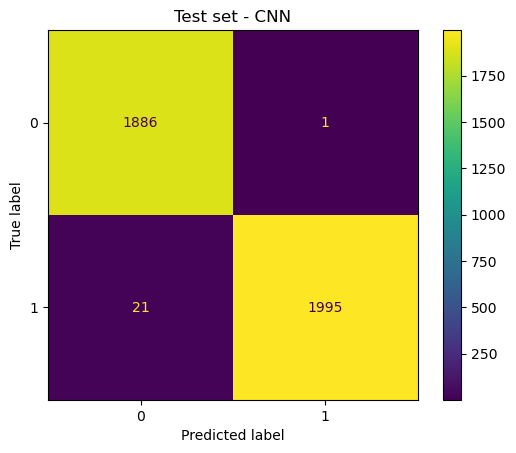

ACC = 0.994363310274148, F1 = 0.9945164506480558, PPV = 0.999498997995992, NPV = 0.9889879391714735, TPR = 0.9895833333333334, TNR = 0.9994700582935877

FPR = 0.0005299417064122947, FNR = 0.010416666666666666
TP = 1995, FP = 1, TN = 1886, FN = 21


In [4]:
p_ts, y_pred_ts, accuracy,f1,PPV,NPV,TPR,TNR,FPR,FNR = EvaluateModel(model, X_test, Y_test)

# 4. Probabilistic Scaling

**Computing $\bar\rho$**

In [5]:
rho_bar, rho_bar01, qhat = ComputeRhoBar(model, X_cal, Y_cal, epsilon)

162/162 [==============================] - 1s 4ms/step


**Computing $\rho^*$**

Albi, questo è il $\rho_\varepsilon$ del paper giusto?

In [6]:
n_c = len(Y_cal.squeeze())
rho_star, rho_bar_sorted = ComputeRhoStar(rho_bar, epsilon, n_c)
print('rho_star = ',rho_star)

rho_star =  0.0816237


# Confusion matrix after probabilistic scaling

ACC = 0.994619523443505, F1 = 0.9947670072265138, PPV = 0.99949924887331, NPV = 0.9895068205666316, TPR = 0.9900793650793651, TNR = 0.9994700582935877

FPR = 0.0005299417064122947, FNR = 0.00992063492063492
TP = 1996, FP = 1, TN = 1886, FN = 20


<Figure size 1200x800 with 0 Axes>

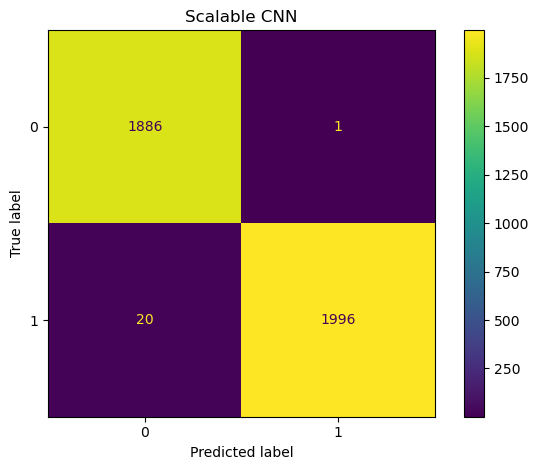

In [7]:
p_ts_star, y_pred_ts_eps, accuracy,f1,PPV,NPV,TPR,TNR,FPR,FNR = EvaluateScalingModel(model,rho_star,p_ts, X_test, Y_test)

# 8. Visualize examples of 'safe' images vs 'unsafe' ($\epsilon = 0.01$)

(1886, 28, 28)
(1, 28, 28)
(1996, 28, 28)


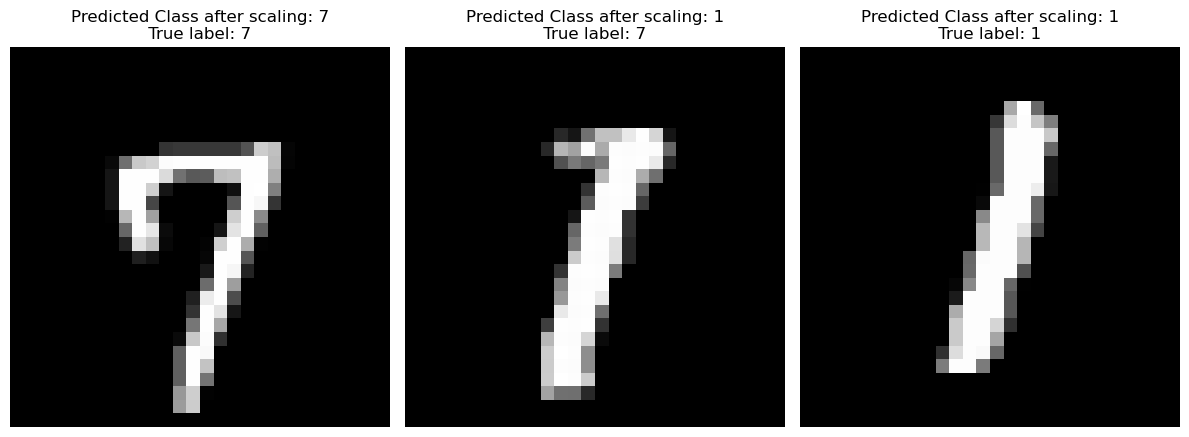

In [15]:
X_test_safe2 = X_test[(Y_test == 0) &  (np.array(y_pred_ts_eps) == 0)]
X_test_unsafe2 = X_test[(Y_test == 0) & (np.array(y_pred_ts_eps) == 1)]
X_test2 = X_test[(Y_test == 1) & (np.array(y_pred_ts_eps) == 1)]
'''
print(X_test_safe2.shape)
print(X_test_unsafe2.shape)
print(X_test2.shape)
'''

X_safe_sample2 = random.sample(list(X_test_safe2),1)
X_unsafe_sample2 = random.sample(list(X_test_unsafe2),1)
X_sample_test2 = random.sample(list(X_test2),1)

X_sample = X_safe_sample2+X_unsafe_sample2+X_sample_test2
Y_sample = [0]*1+[1]*2
Y_real = [0]*2+[1]*1


plt.figure(figsize=(12,8))

for i in range(3):
    plt.subplot(1, 3, i+1)
    
    #img = PIL.Image.open(str(image_file))
    plt.imshow(X_sample[i],cmap = "gray")
     # Remove x and y axis
    plt.axis('off')
    
    label = labels_dict[Y_sample[i]]
    plt.title(f"Predicted Class after scaling: {label}\n True label: {labels_dict[Y_real[i]]} ")
    #plt.savefig(plots_folder + f'71image_{i+1}.pdf', bbox_inches='tight')


plt.tight_layout()
plt.show()


# Isomap scatter plot representation

In [8]:
img_flatten=[]
for i in range(len(X_test)):
    img_flatten.append(X_test[i,:,:].flatten().T)
df = pd.DataFrame(img_flatten)

iso = manifold.Isomap(n_neighbors=6, n_components=2)
iso.fit(df)
manifold_2Da = iso.transform(df)
manifold_2D = pd.DataFrame(manifold_2Da, columns=['Component 1', 'Component 2'])


num_images, num_pixels = df.shape
pixels_per_dimension = int(math.sqrt(num_pixels))

# choice of images to visualize
# class 0 images classified as safe
idx_cls0 = np.where((Y_test == 0) & (np.array(y_pred_ts_eps) == 0))
# class 1 images classified as unsafe
idx_cls1 = np.where((Y_test == 1) & (np.array(y_pred_ts_eps) == 1))
# class 0 images classified as 1 by the scaling
idx_safeoutside = np.where((Y_test == 0) & (np.array(y_pred_ts_eps) == 1))
# class 1 images classified as 0 by the scaling
idx_unsafeinside = np.where((Y_test == 1) & (np.array(y_pred_ts_eps) == 0))

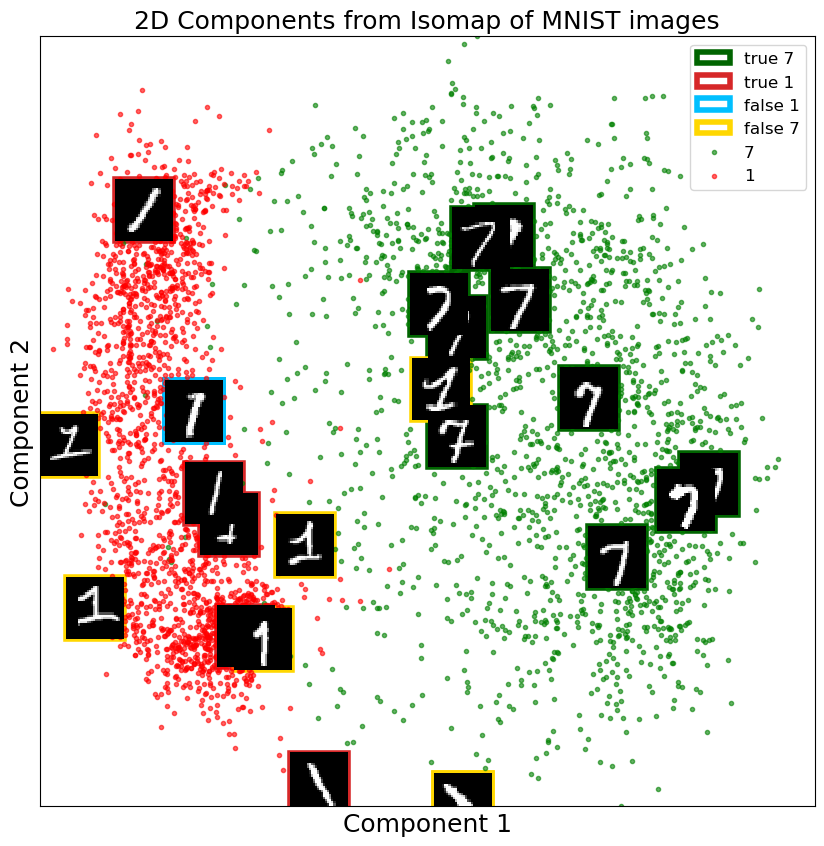

In [12]:
import matplotlib.patches as patches


fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111)
ax.set_title('2D Components from Isomap of MNIST images', fontsize = 18)
ax.set_xlabel('Component: 1', fontsize = 18)
ax.set_ylabel('Component: 2', fontsize = 18)
ax.set_xticks([])
ax.set_yticks([])

# Show 40 of the images ont the plot
x_size = (max(manifold_2D['Component 1']) - min(manifold_2D['Component 1'])) * 0.08
y_size = (max(manifold_2D['Component 2']) - min(manifold_2D['Component 2'])) * 0.08

for i in range(35):
    #img_num = np.random.randint(0, num_images)
    if i < 10:
        img_num = np.random.choice(idx_cls0[0])
    elif i>= 10 and i < 15:
        img_num = np.random.choice(idx_cls1[0])
    elif i>=15 and i<28:
        img_num = np.random.choice(idx_safeoutside[0])
    else:
        img_num = np.random.choice(idx_unsafeinside[0])
        
    
    
    x0 = manifold_2D.loc[img_num, 'Component 1'] - (x_size / 2.)
    y0 = manifold_2D.loc[img_num, 'Component 2'] - (y_size / 2.)
    x1 = manifold_2D.loc[img_num, 'Component 1'] + (x_size / 2.)
    y1 = manifold_2D.loc[img_num, 'Component 2'] + (y_size / 2.)
    #img = df.iloc[img_num,:].values.reshape(pixels_per_dimension, pixels_per_dimension)
    img = X_test[img_num,:,:]
    
    # draw a rectangle around the image

    if i < 10:
        if i == 0:
            rectangle = patches.Rectangle((x0, y0), x_size, y_size, linewidth=4, edgecolor='darkgreen', facecolor='none',label = "true 7")
        else:
            rectangle = patches.Rectangle((x0, y0), x_size, y_size, linewidth=4, edgecolor='darkgreen', facecolor='none')
    elif i>= 10 and i < 15:
        if i == 10:
            rectangle = patches.Rectangle((x0, y0), x_size, y_size, linewidth=4, edgecolor='tab:red', facecolor='none',label = "true 1")
        else:
            rectangle = patches.Rectangle((x0, y0), x_size, y_size, linewidth=4, edgecolor='tab:red', facecolor='none')
    elif i>=15 and i<28:
        if i == 15:
            rectangle = patches.Rectangle((x0, y0), x_size, y_size, linewidth=4, edgecolor='deepskyblue', facecolor='none',label = "false 1")
        else:
            rectangle = patches.Rectangle((x0, y0), x_size, y_size, linewidth=4, edgecolor='deepskyblue', facecolor='none')
    else:
        if i == 28:
            rectangle = patches.Rectangle((x0, y0), x_size, y_size, linewidth=4, edgecolor='gold', facecolor='none', label = "false 7")
        else:
            rectangle = patches.Rectangle((x0, y0), x_size, y_size, linewidth=4, edgecolor='gold', facecolor='none')

    ax.add_patch(rectangle)
    
    ax.imshow(img, aspect='auto', cmap=plt.cm.gray, interpolation='nearest', zorder=100000, extent=(x0, x1, y0, y1))
    #ax.imshow(img, aspect='auto', interpolation='nearest', zorder=100000, extent=(x0, x1, y0, y1))

# Show 2D components plot

ax.scatter(manifold_2D['Component 1'].values[Y_test == 0], manifold_2D['Component 2'].values[Y_test == 0], marker='.',color = 'green',alpha=.6, label = "7")
ax.scatter(manifold_2D['Component 1'].values[Y_test == 1], manifold_2D['Component 2'].values[Y_test == 1], marker='.',color = 'red',alpha=.6, label = "1")

#ax.scatter(manifold_2D['Component 1'].values[np.array(y_pred_ts_eps) == 0], manifold_2D['Component 2'].values[np.array(y_pred_ts_eps) == 0], marker='.',color = 'green',alpha=.7, label = "2 with $P\geq99.9\%$")
#ax.scatter(manifold_2D['Component 1'].values[np.array(y_pred_ts_eps) == 1], manifold_2D['Component 2'].values[np.array(y_pred_ts_eps) == 1], marker='.',color = 'red',alpha=.7, label = "5 or 2 with $P<99.9\%$")

#ax.scatter(manifold_2D['Component 1'].values[(Y_test == 0) &(np.array(y_pred_ts_eps) == 1)], manifold_2D['Component 2'].values[(Y_test == 0) & (np.array(y_pred_ts_eps) == 1)], marker='.',color = 'tab:blue',alpha=.7, label = "FP")
#ax.scatter(manifold_2D['Component 1'].values[(Y_test == 1) & (np.array(y_pred_ts_eps) == 0)], manifold_2D['Component 2'].values[(Y_test == 1) & (np.array(y_pred_ts_eps) == 0)], marker='.',color = 'orange',alpha=.7, label = "FN")

ax.set_ylabel('Component 2')
ax.set_xlabel('Component 1')
plt.ylim([min(manifold_2D['Component 2'].values),max(manifold_2D['Component 2'].values)]) 
ax.legend(fontsize = 12)
#plt.savefig(plots_folder+"isomap_mnist1vs7.pdf")
plt.show()